&nbsp;
<font color=#760202><center><h1>Projet 10</h1></center> <center><h3>Détectez des faux billets</h3></center>
&nbsp;    
# <font color=#2921CA> Introduction
&nbsp;
    
Liste de toutes les méthodes utilisées dans ce notebook qui sont importées à partir des librairies sklearn, statsmodels ou encore scipy     

In [371]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import t, shapiro
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn import preprocessing as pre
from sklearn import cluster as cls
from sklearn import metrics as met

Pour ce projet, je dispose d'un seul jeu de donnée que je nommerai 'billets'

In [372]:
billets = pd.read_csv("C:\\Users\\narab\\OneDrive\\Documents\\OpenClassRooms\\Projet 10\\billets.csv",sep=';')

In [373]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [374]:
billets.shape

(1500, 7)

In [375]:
billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


Ce dataframe est composé de 1500 lignes et 7 variables

Chaque ligne représente un billets, il y a 6 variables quantitatives indiquant des dimensions du billet (exprimées en mm) et 1 variable qualitative indiquant l'authenticité du billet

Parmi ces 1500 billets, il y a 1000 vrais et 500 faux billets

A partir de ces données, l'objectif est d'avoir une modélisation permettant d'identifier l'authenticité d'un billet à partir de ces 6 dimensions

Pour la suite, j'ai décidé de renommer les variables en leur équivalent français abrégé

In [376]:
billets.rename(columns={'is_genuine':'Vrai','diagonal':'diag','height_left':'haut gauche','height_right':'haut droite',
                        'margin_low':'marge inf','margin_up':'marge sup','length':'long'},inplace=True)
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vrai         1500 non-null   bool   
 1   diag         1500 non-null   float64
 2   haut gauche  1500 non-null   float64
 3   haut droite  1500 non-null   float64
 4   marge inf    1463 non-null   float64
 5   marge sup    1500 non-null   float64
 6   long         1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Ci-dessus, on remarque que la variable 'marge inf' comporte 1463 valeurs non nulles au lieu de 1500, c'est un problème qu'il faudra gérer avant d'entamer la modélisation d'authenticité des billets

Mais avant toutes chose, commençons par l'exploration de nos données

&nbsp;
# <font color='blue'> I - Analyse exploratoire
&nbsp;
    
La variable 'Vrai' prenant les valeurs True ou False est de type boolean, je vais plutôt la transformer type category pour une meilleur manipulation
    
Également, je crée en préambule 2 dataframes, l'un avec tous les vrais billets et l'autre avec tous les faux billets    

In [377]:
billets['Vrai'] = billets['Vrai'].astype('category')
vrai = billets[billets['Vrai']==True]
faux = billets[billets['Vrai']==False]
col_vf=['red','green'] #Commande de couleurs pour les graphiques

## <font color='green'> 1) Analyses Univariées
    
Dans cette partie, on va explorer une à une les variables quantitatives du jeu de donnée
    
Pour chacune des variables, je vais regarder la répartition de leurs valeurs tout en différenciant celles correspondant à des vrais ou à des faux billets
    
J'effectuerai également un test de normalité sur la répartition des valeurs
    
Puis j'afficherai les données chiffrées des indicateurs statistiques classiques (moyenne, médiane, quartile, extrêmes...) pour les vrais et les faux billets  
    
Une fois toute les variables explorées, je récapitulerai toutes les informations importantes obtenues lors de cette première exploration, avec lesquels je pourrai extraire des premières analyses concernant la détection de faux billets

### a) Variable 'diag'

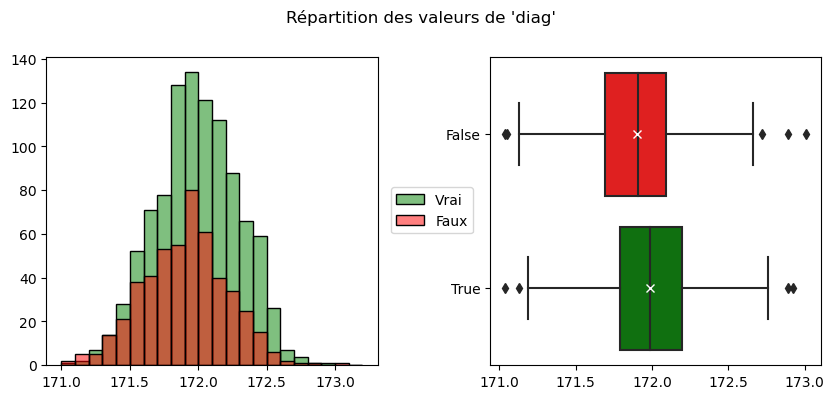

In [378]:
plt.figure(figsize=(10,4))
plt.suptitle("Répartition des valeurs de 'diag'",y=1)

plt.subplot(121)
sns.histplot(data=billets,x='diag',hue='Vrai',palette=col_vf,bins=np.arange(171,173.25,0.1))
plt.xlabel('')
plt.ylabel('')
plt.legend(['Vrai','Faux'],bbox_to_anchor=(1.31,0.6))

plt.subplot(122)
sns.boxplot(data=billets,x='diag',y='Vrai',palette=col_vf,showmeans=True,meanprops={"marker":"x",'markeredgecolor': 'white'})
plt.xlabel('')
plt.ylabel('')

plt.subplots_adjust(wspace=0.34)
plt.show()

Pour cette variable, on observe via l'histogramme que la distribution est plutôt similaire entre vrais et faux billets

La grande majorité se situe entre 171.5 et 172.5, au delà le nombre de billets diminue fortement

Les boxplots nous montre qu'il y a tout de même une petite différence avec 'diag' qui est légèrement inférieure à tous les niveaux statistiques (Moyenne, médiane, quartiles et extrêmes) chez les faux par rapport aux vrais

Également, on note la présence de quelques outliers dans les 2 cas

In [379]:
shapiro_diag = stats.shapiro(billets['diag'])
shapiro_diag_v = stats.shapiro(vrai['diag'])
shapiro_diag_f = stats.shapiro(faux['diag'])
print('Tests de normalité :\n\nH0 = La distribution suit une loi normale\n\nSi p-valeur < 0.05, alors H0 est rejetée'
      '\n\nTous les billets :\n\nStats :',round(shapiro_diag.statistic,2),'\nP-valeur :',round(shapiro_diag.pvalue,3),
      '\n\nVrais billets :\n\nStats :',round(shapiro_diag_v.statistic,2),'\nP-valeur :',round(shapiro_diag_v.pvalue,3),
      '\n\nFaux billets :\n\nStats :',round(shapiro_diag_f.statistic,2),'\nP-valeur :',round(shapiro_diag_f.pvalue,3))

Tests de normalité :

H0 = La distribution suit une loi normale

Si p-valeur < 0.05, alors H0 est rejetée

Tous les billets :

Stats : 1.0 
P-valeur : 0.323 

Vrais billets :

Stats : 1.0 
P-valeur : 0.31 

Faux billets :

Stats : 1.0 
P-valeur : 0.639


Dans les 3 cas, on ne peut rejeter H0

In [380]:
print('Indicateurs statistiques :\n\nVrais billets\n\n',vrai['diag'].describe(),'\n\nFaux billets\n\n',faux['diag'].describe())

Indicateurs statistiques :

Vrais billets

 count    1000.000000
mean      171.987080
std         0.300441
min       171.040000
25%       171.790000
50%       171.990000
75%       172.200000
max       172.920000
Name: diag, dtype: float64 

Faux billets

 count    500.000000
mean     171.901160
std        0.306861
min      171.040000
25%      171.690000
50%      171.910000
75%      172.092500
max      173.010000
Name: diag, dtype: float64


Forcément cela rejoint ce qu'on a pu observer via les boxplots, les chiffres sont proches dont notamment celui de l'écart-type (std) 

### b) Variable 'long'

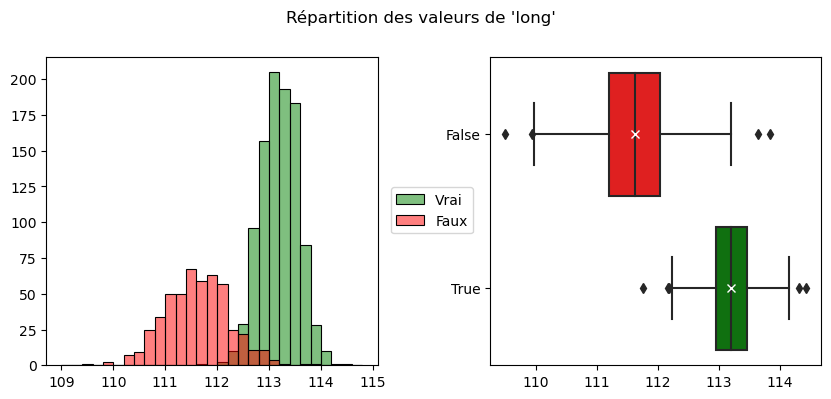

In [381]:
plt.figure(figsize=(10,4))
plt.suptitle("Répartition des valeurs de 'long'",y=1)

plt.subplot(121)
sns.histplot(data=billets,x='long',hue='Vrai',palette=col_vf,bins=np.arange(109,115,0.2))
plt.xlabel('')
plt.ylabel('')
plt.legend(['Vrai','Faux'],bbox_to_anchor=(1.31,0.6))

plt.subplot(122)
sns.boxplot(data=billets,x='long',y='Vrai',palette=col_vf,showmeans=True,meanprops={"marker":"x",'markeredgecolor': 'white'})
plt.xlabel('')
plt.ylabel('')

plt.subplots_adjust(wspace=0.34)
plt.show()

Contrairement au cas précèdement, pour cette variable on a clairement une différence entre vrais et faux billets

On observe que l'intervalle de valeurs commun entre les vrais et faux est assez petit (de 112.2 à 113.2 hors outliers) par rapport à celui de l'ensemble des données (de 110 à 114.2 hors outliers)

Les valeurs des faux billets sont largement inférieures, à tous les niveaux statistiques, de celles des vrais et une grande majorité se situent hors des limites des vrais billets (< 113.2 sauf pour 2 outliers dont un bien éloigné)

In [382]:
shapiro_long = stats.shapiro(billets['long'])
shapiro_long_v = stats.shapiro(vrai['long'])
shapiro_long_f = stats.shapiro(faux['long'])
print('Tests de normalité :\n\nH0 = La distribution suit une loi normale\n\nSi p-valeur < 0.05, alors H0 est rejetée'
      '\n\nTous les billets :\n\nStats :',round(shapiro_long.statistic,2),'\nP-valeur :',round(shapiro_long.pvalue,3),
      '\n\nVrais billets :\n\nStats :',round(shapiro_long_v.statistic,2),'\nP-valeur :',round(shapiro_long_v.pvalue,3),
      '\n\nFaux billets :\n\nStats :',round(shapiro_long_f.statistic,2),'\nP-valeur :',round(shapiro_long_f.pvalue,3))

Tests de normalité :

H0 = La distribution suit une loi normale

Si p-valeur < 0.05, alors H0 est rejetée

Tous les billets :

Stats : 0.92 
P-valeur : 0.0 

Vrais billets :

Stats : 1.0 
P-valeur : 0.304 

Faux billets :

Stats : 1.0 
P-valeur : 0.527


On rejette H0 pour le cas général, par contre on ne peut rejeter H0 lorsqu'on sépare les vrais et les faux billets

In [383]:
print('Indicateurs statistiques :\n\nVrais billets\n\n',vrai['long'].describe(),'\n\nFaux billets\n\n',faux['long'].describe())

Indicateurs statistiques :

Vrais billets

 count    1000.000000
mean      113.202430
std         0.359552
min       111.760000
25%       112.950000
50%       113.205000
75%       113.460000
max       114.440000
Name: long, dtype: float64 

Faux billets

 count    500.000000
mean     111.630640
std        0.615543
min      109.490000
25%      111.200000
50%      111.630000
75%      112.030000
max      113.850000
Name: long, dtype: float64


Ici, c'est intéressant de regarder les bornes dans chacun des cas

Le minimun pour les vrais billets est de 111.76, alors que la médiane des faux est de 111.63 et n'atteint même pas ce cap

Le maximun pour les faux billets est de 113.85 et dépasse tout de même et de loin le 3ème quartile des vrais qui est de 113.46

Pour cette variable, on a observé de grosses différences entre les vrais et les faux billets avec notamment plus de la moitié des faux billets hors des bornes des vrais billets

### c) Variable 'haut gauche'

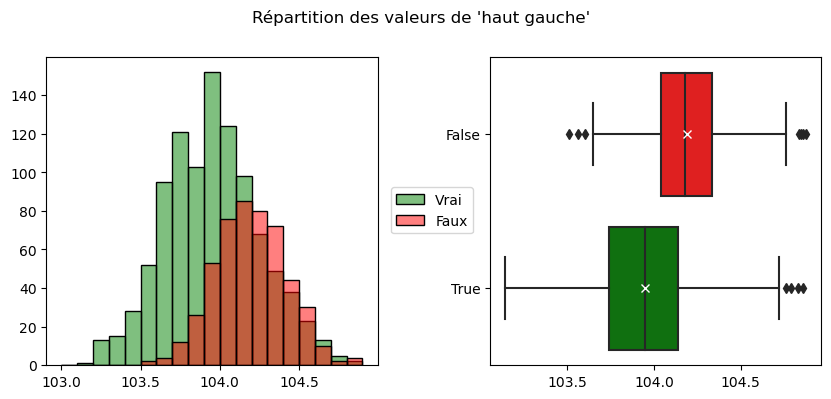

In [384]:
plt.figure(figsize=(10,4))
plt.suptitle("Répartition des valeurs de 'haut gauche'",y=1)

plt.subplot(121)
sns.histplot(data=billets,x='haut gauche',hue='Vrai',palette=col_vf,bins=np.arange(103,105,0.1))
plt.xlabel('')
plt.ylabel('')
plt.legend(['Vrai','Faux'],bbox_to_anchor=(1.31,0.6))

plt.subplot(122)
sns.boxplot(data=billets,x='haut gauche',y='Vrai',palette=col_vf,showmeans=True,meanprops={"marker":"x",'markeredgecolor': 'white'})
plt.xlabel('')
plt.ylabel('')

plt.subplots_adjust(wspace=0.34)
plt.show()

Ici, on observe un autre cas de figure par rapport aux 2 précédents

Les valeurs pour les faux billets sont comprises dans les bornes des vrais billets (hormis quelques outliers), par contre la distribution des faux est décalée vers la droite par rapport à celle des vrais et donc des valeurs supérieures à tous les niveaux statistiques

Avant 103.5, on observe seulement une petite partie composé uniquement de vrais billets

Après 104.2, le nombre de faux billets devient majoritaire

Pour cette variable, il n'y a pas de limites permettant d'identifier directement un faux billets

In [385]:
shapiro_haut_gauche = stats.shapiro(billets['haut gauche'])
shapiro_haut_gauche_v = stats.shapiro(vrai['haut gauche'])
shapiro_haut_gauche_f = stats.shapiro(faux['haut gauche'])
print('Tests de normalité :\n\nH0 = La distribution suit une loi normale\n\nSi p-valeur < 0.05, alors H0 est rejetée'
      '\n\nTous les billets :\n\nStats :',round(shapiro_haut_gauche.statistic,2),'\nP-valeur :',round(shapiro_haut_gauche.pvalue,3),
      '\n\nVrais billets :\n\nStats :',round(shapiro_haut_gauche_v.statistic,2),'\nP-valeur :',round(shapiro_haut_gauche_v.pvalue,3),
      '\n\nFaux billets :\n\nStats :',round(shapiro_haut_gauche_f.statistic,2),'\nP-valeur :',round(shapiro_haut_gauche_f.pvalue,3))

Tests de normalité :

H0 = La distribution suit une loi normale

Si p-valeur < 0.05, alors H0 est rejetée

Tous les billets :

Stats : 1.0 
P-valeur : 0.051 

Vrais billets :

Stats : 1.0 
P-valeur : 0.029 

Faux billets :

Stats : 1.0 
P-valeur : 0.791


On ne rejette pas H0 pour la distribution générale, c'est toujours le cas pour celles des faux billets, par contre on doit rejetter H0 pour celle des vrais billets

In [386]:
print('Indicateurs statistiques :\n\nVrais billets\n\n',vrai['haut gauche'].describe(),'\n\nFaux billets\n\n',faux['haut gauche'].describe())

Indicateurs statistiques :

Vrais billets

 count    1000.000000
mean      103.949130
std         0.300231
min       103.140000
25%       103.740000
50%       103.950000
75%       104.140000
max       104.860000
Name: haut gauche, dtype: float64 

Faux billets

 count    500.000000
mean     104.190340
std        0.223758
min      103.510000
25%      104.040000
50%      104.180000
75%      104.332500
max      104.880000
Name: haut gauche, dtype: float64


On a un maximum quasiment égale pour les 2 types de billets (cela doit se jouer à 1 ou 2 billets près) et un minimum des faux billets compris entre le minimum et le 1er quartile des vrais billets

### d) Variable 'haut droite'

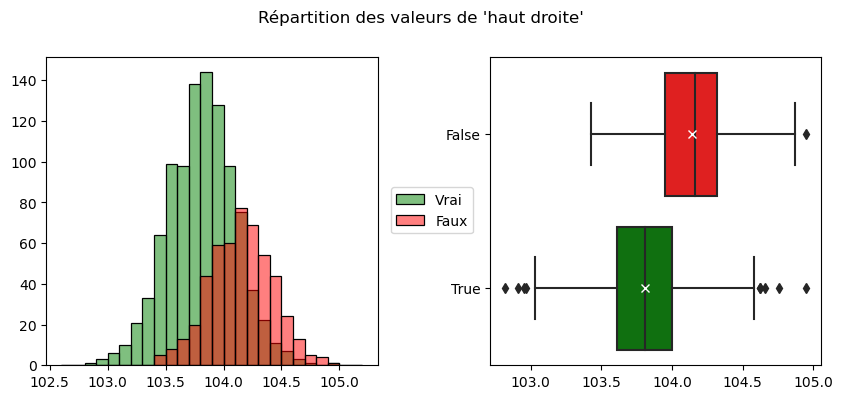

In [387]:
plt.figure(figsize=(10,4))
plt.suptitle("Répartition des valeurs de 'haut droite'",y=1)

plt.subplot(121)
sns.histplot(data=billets,x='haut droite',hue='Vrai',palette=col_vf,bins=np.arange(102.6,105.2,0.1))
plt.xlabel('')
plt.ylabel('')
plt.legend(['Vrai','Faux'],bbox_to_anchor=(1.31,0.6))

plt.subplot(122)
sns.boxplot(data=billets,x='haut droite',y='Vrai',palette=col_vf,showmeans=True,meanprops={"marker":"x",'markeredgecolor': 'white'})
plt.xlabel('')
plt.ylabel('')

plt.subplots_adjust(wspace=0.34)
plt.show()

Ici, on a un cas qui s'apparente à celui juste au dessus de 'haut gauche', c'est à dire une distribution des faux billets comprises entre les bornes des vrais billets et décalée vers la droite par rapport à celle des vrais

On retrouve également un seuil où il n'y a que des vrais billets (sous les 103.4) et un seuil où le nombre de faux billets devient majoritaire (après 104.1)

La seule différence notable, c'est que le ratio faux/vrais est beaucoup plus important après le seuil de la majorité de faux que pour celui de la variable 'haut gauche'

On voit que la branche maximun des faux est bien supérieure à celle des vrais, cependant on note la présence de 4 outliers chez les vrais dont un qui vient dépasser cette branche et même l'outlier maximun des faux

In [388]:
stats.shapiro(billets['haut droite'])

ShapiroResult(statistic=0.9995179772377014, pvalue=0.9806053638458252)

In [389]:
shapiro_haut_droite = stats.shapiro(billets['haut droite'])
shapiro_haut_droite_v = stats.shapiro(vrai['haut droite'])
shapiro_haut_droite_f = stats.shapiro(faux['haut droite'])
print('Tests de normalité :\n\nH0 = La distribution suit une loi normale\n\nSi p-valeur < 0.05, alors H0 est rejetée'
      '\n\nTous les billets :\n\nStats :',round(shapiro_haut_droite.statistic,2),'\nP-valeur :',round(shapiro_haut_droite.pvalue,3),
      '\n\nVrais billets :\n\nStats :',round(shapiro_haut_droite_v.statistic,2),'\nP-valeur :',round(shapiro_haut_droite_v.pvalue,3),
      '\n\nFaux billets :\n\nStats :',round(shapiro_haut_droite_f.statistic,2),'\nP-valeur :',round(shapiro_haut_droite_f.pvalue,3))

Tests de normalité :

H0 = La distribution suit une loi normale

Si p-valeur < 0.05, alors H0 est rejetée

Tous les billets :

Stats : 1.0 
P-valeur : 0.981 

Vrais billets :

Stats : 1.0 
P-valeur : 0.587 

Faux billets :

Stats : 1.0 
P-valeur : 0.827


H0 : la distribution suit une loi normale

Dans les 3 cas, on ne rejette pas H0

In [390]:
print('Indicateurs statistiques :\n\nVrais billets\n\n',vrai['haut droite'].describe(),'\n\nFaux billets\n\n',faux['haut droite'].describe())

Indicateurs statistiques :

Vrais billets

 count    1000.00000
mean      103.80865
std         0.29157
min       102.82000
25%       103.61000
50%       103.81000
75%       104.00000
max       104.95000
Name: haut droite, dtype: float64 

Faux billets

 count    500.000000
mean     104.143620
std        0.270878
min      103.430000
25%      103.950000
50%      104.160000
75%      104.320000
max      104.950000
Name: haut droite, dtype: float64


Également, on a un maximum quasiment égale pour les 2 types de billets (qui se joue à un billet près) et un minimum des faux billets compris entre le minimum et le 1er quartile des vrais billets

### e) Variable 'marge sup'

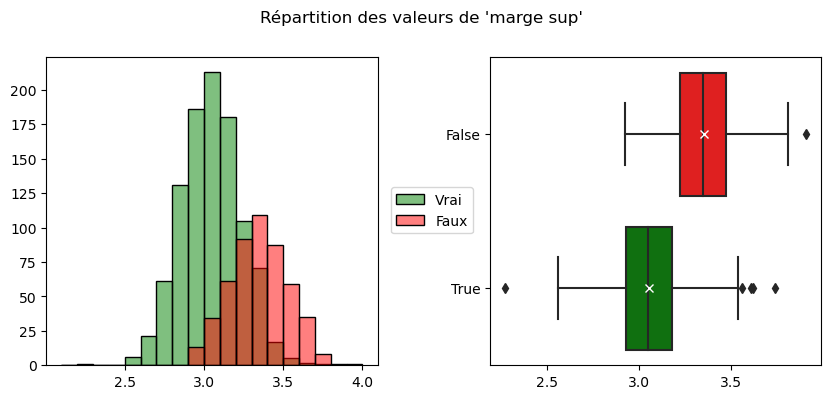

In [391]:
plt.figure(figsize=(10,4))
plt.suptitle("Répartition des valeurs de 'marge sup'",y=1)

plt.subplot(121)
sns.histplot(data=billets,x='marge sup',hue='Vrai',palette=col_vf,bins=np.arange(2.1,4.1,0.1))
plt.xlabel('')
plt.ylabel('')
plt.legend(['Vrai','Faux'],bbox_to_anchor=(1.31,0.6))

plt.subplot(122)
sns.boxplot(data=billets,x='marge sup',y='Vrai',palette=col_vf,showmeans=True,meanprops={"marker":"x",'markeredgecolor': 'white'})
plt.xlabel('')
plt.ylabel('')

plt.subplots_adjust(wspace=0.34)
plt.show()

Ici, on a un cas proche du précédent, mais légèrement différent en ce qui concerne les maximubs

La distribution des faux billets est également décalée vers la gauche par rapport aux vrais, par contre , cette fois-ci on a quelques valeurs parmi les faux billets qui dépassent la borne maximun des vrais billets

In [392]:
shapiro_marge_sup = stats.shapiro(billets['marge sup'])
shapiro_marge_sup_v = stats.shapiro(vrai['marge sup'])
shapiro_marge_sup_f = stats.shapiro(faux['marge sup'])
print('Tests de normalité :\n\nH0 = La distribution suit une loi normale\n\nSi p-valeur < 0.05, alors H0 est rejetée'
      '\n\nTous les billets :\n\nStats :',round(shapiro_marge_sup.statistic,2),'\nP-valeur :',round(shapiro_marge_sup.pvalue,3),
      '\n\nVrais billets :\n\nStats :',round(shapiro_marge_sup_v.statistic,2),'\nP-valeur :',round(shapiro_marge_sup_v.pvalue,3),
      '\n\nFaux billets :\n\nStats :',round(shapiro_marge_sup_f.statistic,2),'\nP-valeur :',round(shapiro_marge_sup_f.pvalue,3))

Tests de normalité :

H0 = La distribution suit une loi normale

Si p-valeur < 0.05, alors H0 est rejetée

Tous les billets :

Stats : 1.0 
P-valeur : 0.001 

Vrais billets :

Stats : 1.0 
P-valeur : 0.355 

Faux billets :

Stats : 1.0 
P-valeur : 0.193


Pour le cas général, on rejette H0 mais pour les cas séparés on ne rejette pas H0 

In [393]:
print('Indicateurs statistiques :\n\nVrais billets\n\n',vrai['marge sup'].describe(),'\n\nFaux billets\n\n',faux['marge sup'].describe())

Indicateurs statistiques :

Vrais billets

 count    1000.00000
mean        3.05213
std         0.18634
min         2.27000
25%         2.93000
50%         3.05000
75%         3.18000
max         3.74000
Name: marge sup, dtype: float64 

Faux billets

 count    500.000000
mean       3.350160
std        0.180498
min        2.920000
25%        3.220000
50%        3.350000
75%        3.472500
max        3.910000
Name: marge sup, dtype: float64


Le minimun des faux est proche du 1er quartile des vrais

Le maximun des faux est supérieur à celui des vrais, mais on peut voir que c'est l'écart le moins important de tous les indicateurs du fait d'un outlier chez les vrais billets

### f) Variable 'marge inf'

Pour rappel, c'est l'unique variable présentant des valeurs nulles qu'il faudra gérer avant d'entamer la partie dédiée à la détection de faux billets

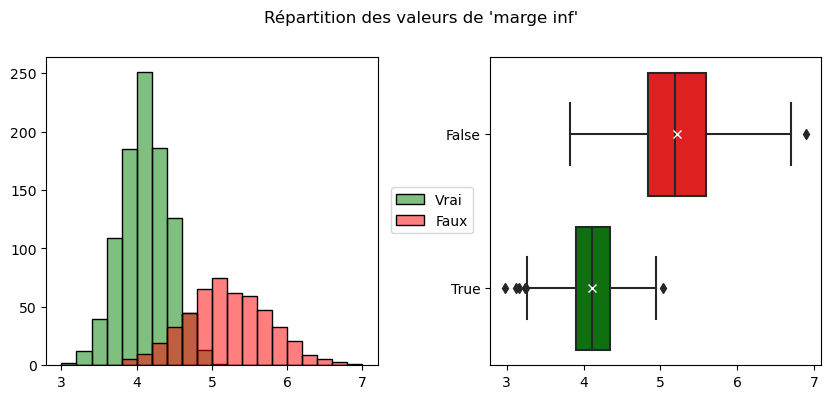

In [394]:
plt.figure(figsize=(10,4))
plt.suptitle("Répartition des valeurs de 'marge inf'",y=1)

plt.subplot(121)
sns.histplot(data=billets,x='marge inf',hue='Vrai',palette=col_vf,bins=np.arange(3,7.2,0.2))
plt.xlabel('')
plt.ylabel('')
plt.legend(['Vrai','Faux'],bbox_to_anchor=(1.31,0.6))

plt.subplot(122)
sns.boxplot(data=billets,x='marge inf',y='Vrai',palette=col_vf,showmeans=True,meanprops={"marker":"x",'markeredgecolor': 'white'})
plt.xlabel('')
plt.ylabel('')

plt.subplots_adjust(wspace=0.34)
plt.show()

Ici, on retrouve un cas plutôt semblable à celui de 'long' où on a une grande majorité hors des bornes des vrais billets, avec également plus de la moitié des billets dont la valeur est supérieure au maximun des vrais

On a aussi une petite partie des vrais (presque 1/4) sous le minimun des faux

L'intervalle de valeur commune est plutôt compris entre 3.8 et 5, alors que pour l'ensemble des billets, les valeurs varient de 3 à 7

In [395]:
vrai_nn = vrai[vrai['marge inf'].notnull()]
faux_nn = faux[faux['marge inf'].notnull()]
shapiro_marge_inf = stats.shapiro(billets['marge inf'].notnull())
shapiro_marge_inf_v = stats.shapiro(vrai_nn['marge inf'])
shapiro_marge_inf_f = stats.shapiro(faux_nn['marge inf'])
print('Tests de normalité :\n\nH0 = La distribution suit une loi normale\n\nSi p-valeur < 0.05, alors H0 est rejetée'
      '\n\nTous les billets :\n\nStats :',round(shapiro_marge_inf.statistic,2),'\nP-valeur :',round(shapiro_marge_inf.pvalue,3),
      '\n\nVrais billets :\n\nStats :',round(shapiro_marge_inf_v.statistic,2),'\nP-valeur :',round(shapiro_marge_inf_v.pvalue,3),
      '\n\nFaux billets :\n\nStats :',round(shapiro_marge_inf_f.statistic,2),'\nP-valeur :',round(shapiro_marge_inf_f.pvalue,3))

Tests de normalité :

H0 = La distribution suit une loi normale

Si p-valeur < 0.05, alors H0 est rejetée

Tous les billets :

Stats : 0.14 
P-valeur : 0.0 

Vrais billets :

Stats : 1.0 
P-valeur : 0.5 

Faux billets :

Stats : 1.0 
P-valeur : 0.555


Pour le cas général, on rejette H0 mais pour les cas séparés on ne rejette pas H0 

In [396]:
print('Indicateurs statistiques :\n\nVrais billets\n\n',vrai['marge inf'].describe(),'\n\nFaux billets\n\n',faux['marge inf'].describe())

Indicateurs statistiques :

Vrais billets

 count    971.000000
mean       4.116097
std        0.319124
min        2.980000
25%        3.905000
50%        4.110000
75%        4.340000
max        5.040000
Name: marge inf, dtype: float64 

Faux billets

 count    492.000000
mean       5.215935
std        0.553531
min        3.820000
25%        4.840000
50%        5.190000
75%        5.592500
max        6.900000
Name: marge inf, dtype: float64


Le maximun des vrais billets est de 5.04, inférieur à la médiane des faux égale à 5.19

Le minimun des faux billets est de 3.82, légèrement inférieure au 1er quartile des vrais égal à 3.9, mais bien supérieur au minimun des vrais billets égal à 2.98 

## Récapitulatif

En ce qui concerne la répartition des valeurs entre vrais et faux billets, on a pu observer qu'il y avait des différences plus ou moins notables selon les variables que l'on peut classer en 3 degrés de différence

- **1er degré : 'diag'**

Avec des bornes minimun et maximun équivalentes et de légères différences aux niveau des indicateurs statistiques

On peut supposer que cette variable sera très peu significative pour la détection des faux billets

- **2ème degré : 'haut gauche', 'haut droite' et 'marge sup'**

Pour les 3 variables, on a distribution pour les faux billets décalée vers la droite par rapport aux vrais billets

Chacune de ces variables comportent un intervalle de valeurs dans lequel se situe uniquement une minorité de vrais billets

Le nombre de faux billets devient majoritaire à partir d'un seuil propore à chacune des variables

Hormis 1 ou 2 outliers, l'ensemble des valeurs des faux billets est compris dans celui des vrais billets

On aura une tendance à des valeurs plus élevées chez les faux billets et forcément, on peut supposer que ces variables seront plus significatives que 'diag' pour la détection des faux billets 

- **3ème degré : 'long' et 'marge inf'**

Pour ces 2 variables, on a observé une distribution avec 3 intervalles de valeurs différentes

Il y a un intervalle composé uniquement de faux billets, un autre avec uniquement des vrais billets et le dernier, situé entre les 2, dans lequel figurent des faux et des vrais billets

A partir des limites des vrais billets de ces 2 variables (en deça du minimun pour 'long' et au delà du maximun pour 'marge inf'), on pourra détecter directement un faux billet

Logiquement, on peut supposer que ces 2 variables seront les plus significatives pour la détection de faux billets

&nbsp;

On peut noter les valeurs des limites pour lesquelles un billet serait directement considérer comme faux (et comme vrai pour la curiosité)

**FAUX BILLETS :**

- long  <  111.76


- marge inf  >  5.04


- marge sup  >  3.74


- diag  >  172.92



**VRAIS BILLETS :**

- haut droite < 103.43


- marge inf < 3.82


- marge sup < 2.92

&nbsp;

# **Remarque** : on a effectuté des tests de normalité sur les distributions des vrais et des faux billets pour chacune des variables, seule la distribution des vrais billets de 'haut gauche' rejette l'hypothèse de normalité

TOUS
Pearson : haut droite, haut gauche, diag
Spearman : marge inf, marge sup, long

VRAIS
Pearson : marge inf, marge sup, haut droite, long, diag
Spearman : haut gauche

FAUX
Pearson : marge inf, marge sup, haut droite, haut gauche, long, diag
Spearman : 


&nbsp;

# <font color='green'> 2) Analyse bivariée
    
Maintenant, je vais regarder comment les variables se comportent en fonction des autres variables
    
Pour cela, j'observerai les nuages de points et les corrélations des variables deux à deux    

<Figure size 400x400 with 0 Axes>

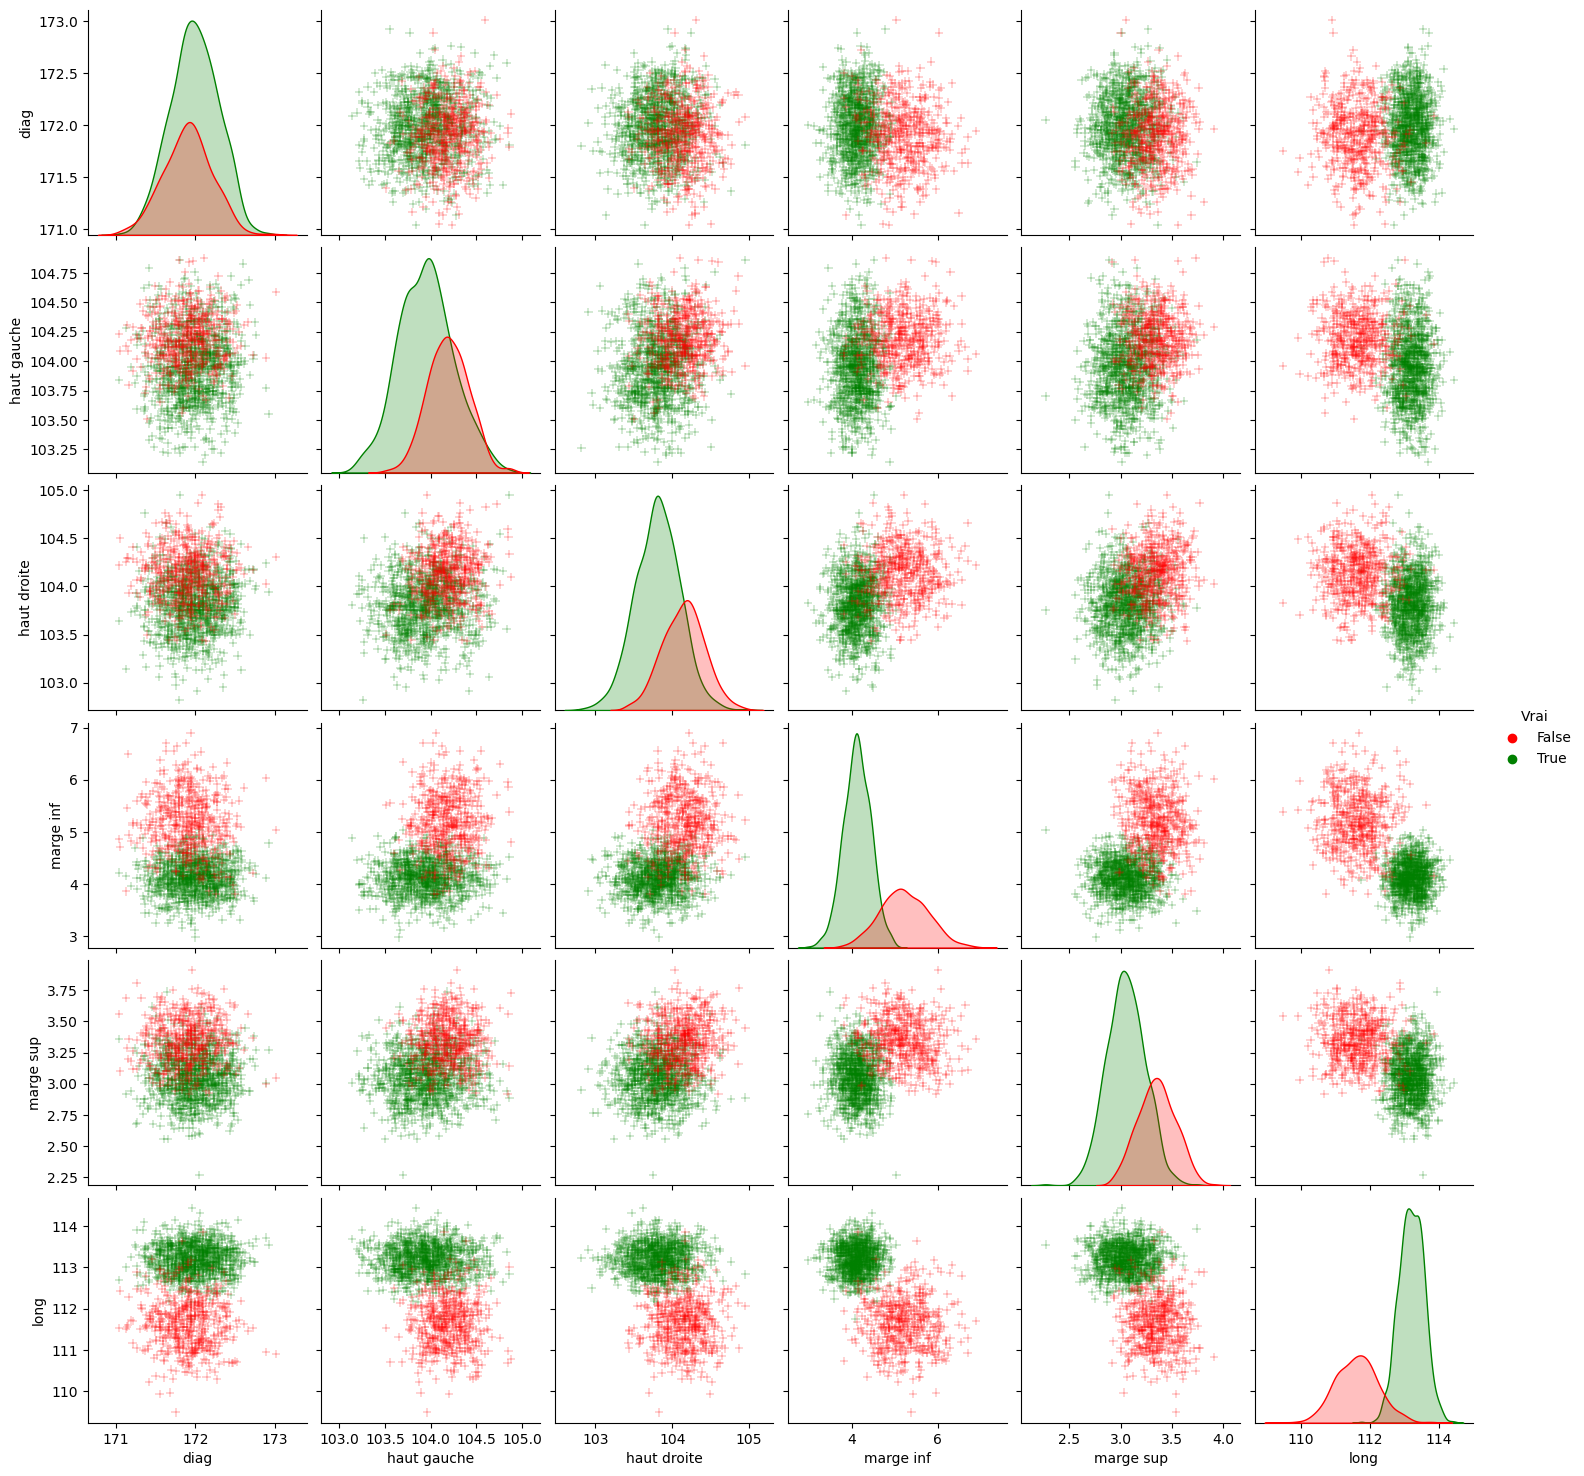

In [397]:
plt.figure(figsize=(4,4))

sns.pairplot(billets,hue='Vrai',plot_kws=dict(marker="+", linewidth=0.25),palette=col_vf)

plt.show()

On retrouve logiquement des informations obtenues dans la partie précédente, notamment sur les degrés de différence que j'ai évoqué dans le récapitulatif avec la variable 'diag' pour laquelle les points verts et rouges sont plus mélangées, alors que si on prend le nuage de points de 'marge inf' et 'long', on observe un groupe vert avec quelques points rouges et inversement

A la place des histogrammes observés dans la partie précédente, on a des courbes de densités, ce qui rend la différentiation entre vrais et faux billets plus simple

J'avais classé selon des degrés de différentiation les variables, on peut encore mieux estimer un ordre d'importance des variables qui permettront de détecter un faux billets : 'long' > 'marge inf' > 'marge sup' > 'haut droite' > 'haut gauche' > 'diag' 

Il est également intéressant de bien observer les formes des nuages de points afin de voir s'il y a des tendances linéaires entre les variables et d'autant plus ceux avec 'marge inf' vu qu'on devra s'occuper des valeurs manquantes de cette dernière

Pour 'marge inf', on a peut-être un semblant de quelque chose avec 'haut droite' et en général on a une jolie forme "croissante" entre 'haut droite' et 'marge sup'

A l'oeil nu, ce n'est pas forcément évident, il sera préférable de regarder les coefficients de corrélations de toutes nos variables entre elles

In [398]:
billets_corr = billets.corr(method='spearman')
def rg(val):
    
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

billets_corr_rg = billets_corr.style.applymap(rg).applymap(lambda v: 'opacity: 40%;' if (v < 0.4) and (v > -0.4) else None)
                                         
billets_corr_rg

,diag,haut gauche,haut droite,marge inf,marge sup,long
diag,1.000000,0.020055,-0.029748,-0.104360,-0.051097,0.096150
haut gauche,0.020055,1.000000,0.254122,0.297401,0.260195,-0.308700
haut droite,-0.029748,0.254122,1.000000,0.396651,0.302853,-0.370605
marge inf,-0.104360,0.297401,0.396651,1.000000,0.421361,-0.587506
marge sup,-0.051097,0.260195,0.302853,0.421361,1.000000,-0.479832
long,0.096150,-0.308700,-0.370605,-0.587506,-0.479832,1.000000


On note qu'il y a 3 corrélations modérées :

La plus forte entre 'marge inf' et long à -0.59, ensuite entre 'marge sup' et 'long' à -0.48, puis entre 'marge inf' et 'marge sup' à 0.42

On peut également noter des faibles corrélations entre 'marge inf' et 'haut droite' à 0.4, entre 'haut droite' et 'long' à -0.37 et entre 'marge sup' et 'haut droite' à 0.3

On a un trio de variables, composé de 'marge inf', 'marge sup' et 'long', qui se partagent les corrélations les plus importantes, auquel on peut ajouter 'haut droite' pour des corrélations légèrement moins importantes

On remarquera que 'haut gauche' et surtout 'diag' sont les variables avec les coefficients de corrélations les plus faibles et que ces 2 variables sont aussi celles qui montraient le moins de différence entre vrais et faux billets

# <font color='green'> C) Partie bonus de l'analyse exploratoire 

On a vu qu'il y avait des distributions de valeurs pour les faux billets hors des limites des valeurs des vrais billets, en particulier pour les variables 'marge inf' et 'long'
    
Dans cette partie, je vais juste creuser, par curiosité, à propos de ces limites     
### Rappel    
    
**FAUX BILLETS :**

- long  <  111.76


- marge inf  >  5.04


- marge sup  >  3.74


- diag  >  172.92



**VRAIS BILLETS :**

- haut droite < 103.43


- marge inf < 3.82


- marge sup < 2.92    

In [399]:
faux.loc[faux['diag']>172.92].shape

(1, 7)

In [400]:
faux.loc[faux['long']<111.76].shape

(286, 7)

In [401]:
faux.loc[faux['marge inf']>5.04].shape

(304, 7)

In [402]:
vrai.loc[vrai['marge inf']<3.82].shape

(173, 7)

In [403]:
vrai.loc[vrai['haut droite']<103.43].shape

(91, 7)

In [404]:
vrai.loc[vrai['marge sup']<2.92].shape

(230, 7)

In [405]:
faux.loc[faux['marge sup']>3.74].shape

(6, 7)

A partir de ces informations, on peut déjà établir quelques conditions pour qu'un billet soit un vrai ou non :

- diag > 172.92 = faux (1 faux)

- long < 111.76 = faux (286 faux)

- haut gauche - aucune condition

- haut droite < 103.43 = vrai (91 vrais) 

- marge inf < 3.82 = vrai (173 vrais) et marge inf > 5.04 = faux (304 faux)

- marge sup < 2.92 = vrai (230 vrais) et marge sup > 3.74 = faux (6 faux)

Ceci pourra servir de base pour la détection de faux billets

On pourra donc au préalable supprimer tous les billets validant ces conditions et se concentrer sur ceux qu'ils restent

Regardons combien de billets nous restent-ils quand l'ensemble des conditions sont validés

In [406]:
billets2 = billets.copy()

In [407]:
billets2.loc[(billets2['haut droite']<103.43)|(billets2['marge inf']<3.82)|(billets2['marge sup']<2.92)].shape

(428, 7)

Pour les vrais billets, on en a déjà 428/1000 qui valident ces conditions 

In [408]:
billets2.loc[(billets2['diag']>172.92)|(billets2['long']<111.76)|(billets2['marge inf']>5.04)|(billets2['marge sup']>3.74)].shape

(417, 7)

Pour les faux billets, on en a déjà 417/500 qui valident ces conditions 

In [409]:
billets2['lim'] = 'ras'
billets2['lim'][(billets2['haut droite']<103.43)|(billets2['marge inf']<3.82)|(billets2['marge sup']<2.92)] = 'v'
billets2['lim'][(billets2['diag']>172.92)|(billets2['long']<111.76)|(billets2['marge inf']>5.04)|(billets2['marge sup']>3.74)] = 'f'

C:\Users\narab\AppData\Local\Temp\ipykernel_1220\711288547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets2['lim'][(billets2['haut droite']<103.43)|(billets2['marge inf']<3.82)|(billets2['marge sup']<2.92)] = 'v'
C:\Users\narab\AppData\Local\Temp\ipykernel_1220\711288547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets2['lim'][(billets2['diag']>172.92)|(billets2['long']<111.76)|(billets2['marge inf']>5.04)|(billets2['marge sup']>3.74)] = 'f'


In [410]:
billets2 = billets2[billets2['lim']=='ras']

In [411]:
billets2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 655 entries, 2 to 1499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Vrai         655 non-null    category
 1   diag         655 non-null    float64 
 2   haut gauche  655 non-null    float64 
 3   haut droite  655 non-null    float64 
 4   marge inf    630 non-null    float64 
 5   marge sup    655 non-null    float64 
 6   long         655 non-null    float64 
 7   lim          655 non-null    object  
dtypes: category(1), float64(6), object(1)
memory usage: 41.7+ KB


Avec ces conditions on aurait plus que 655 billets dont seulement 83 faux (soit 12.8% au lieu de 33.3%)

&nbsp;
# <font color='blue'> II - Gestion des valeurs nulles de 'marge inf'  
&nbsp;
    
Pour gérer les valeurs nulles, il existe une multitude de façons de faire, la plus courante est l'imputation par la moyenne ou la médiane, mais cette méthode est loin d'être la plus précise et peut présenter une marge d'erreur conséquente entre la valeur imputée et la vraie valeur
    
Ici notre jeu de donnée concerne des billets et le but n'est clairement pas de remplacer les valeurs manquantes par une estimation à la louche

Il existe une méthode qui consiste à prédire la valeur d'une variable quantitative à partir d'autres variables quantitatives
    
Cette méthode s'appelle la régression linéaire et s'exprime telle que :
    
Y = c0 + c1*X1 + c2*X2 + ... + cn*Xn + e où Y est la variable à prédir, les Xi sont les variables (dites explicatives) permettant la prédiction, les ci sont des constantes et e est le terme d'erreur
    
C'est cette méthode que je vais utliser pour prédir les valeurs manquantes de 'marge inf'

Pour commencer, je vais créer 2 dataframes, l'un avec les valeurs non nulles et l'autre avec les valeurs nulles    

In [412]:
billets_vn = billets.loc[billets['marge inf'].isnull()==True]
billets_nn = billets.dropna()
print("Le dataframe possédant les billets dont la valeur de 'marge inf' est nulle est composé de",
      len(billets_vn[billets_vn['Vrai']==True]),"vrais billets et de",len(billets_vn[billets_vn['Vrai']==False]),
      "faux billets\n\nLe dataframe sans les valeurs nulles est composé de",len(billets_nn[billets_nn['Vrai']==True]),
      "vrais billets et de",len(billets_nn[billets_nn['Vrai']==False]),"faux billets")

Le dataframe possédant les billets dont la valeur de 'marge inf' est nulle est composé de 29 vrais billets et de 8 faux billets

Le dataframe sans les valeurs nulles est composé de 971 vrais billets et de 492 faux billets


On constaste qu'il y a les 2 types de billets parmi ceux qui présentent une valeur nulle dans la colonne 'marge inf' (en soit le ratio importe peu)

Pour effectuer la régression linéaire, j'aurais donc Y = 'marge inf' et les Xi = aux 5 autres variables quantitatives, néanmoins on a pu constaster qu'il y avait une forte différence dans la distribution des valeurs de 'marge inf' pour les vrais et les faux billets

Exclure la variable 'Vrai' dans la prédiction des valeurs de 'marge inf' ne serait peut-être pas le plus judicieux, mais la variable 'Vrai', n'étant pas une variable quantitative, ne fonctionnera pas dans la régression linéaire comme possible variable explicative

Il existe une méthode permettant de transformer une variable qualitative en plusieurs variables quantitatives prenant les valeurs 0 ou 1, où le nombre de variables quantitatives correspond au nombre de modalités de la variable qualitative. De plus en supprimant une des variables quantitatives créées par cette méthode, on obtient toutes les combinaisons permettant d'identifier la modalité

Pour le cas de la variable 'Vrai', une seule variable quantitative sera nécessaire

In [413]:
billets_nn.head()

,Vrai,diag,haut gauche,haut droite,marge inf,marge sup,long
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [414]:
col = pd.get_dummies(billets_nn['Vrai'],drop_first=True,dtype=float)
billets_nn = pd.concat([billets_nn.drop(columns='Vrai'),col],axis=1)
billets_nn.rename(columns={True:'Vrai'},inplace=True)
billets_nn.head()

,diag,haut gauche,haut droite,marge inf,marge sup,long,Vrai
0,171.81,104.86,104.95,4.52,2.89,112.83,1.0
1,171.46,103.36,103.66,3.77,2.99,113.09,1.0
2,172.69,104.48,103.50,4.40,2.94,113.16,1.0
3,171.36,103.91,103.94,3.62,3.01,113.51,1.0
4,171.73,104.28,103.46,4.04,3.48,112.54,1.0


La variable 'Vrai' est maintenant de type float où 1 = True et 0 = False

Maintenant je peux utiliser toutes mes variables afin d'appliquer la régression linéaire

Il existe pour Python, des librairies fournissant directement des méthodes appliquant algorithmes de régression linéaire. Les 2 libraires les plus connues sont SKLEARN et STATSMODELS, la première étant plus orientée pour du marching learning et la seconde étant plus orientée pour de l'explication statistique
Autant utiliser les méthodes provenant de ces 2 librairies, je pourrai comparer les résultats obtenus et garder le meilleur des 2

Je vais commencer par utiliser SKLEARN, mais quoiqu'il en soit le départ reste commun puisqu'il faut séparer le dataframe en 2

En effet il y aura Y la variable à prédire ('marge inf') et X = l'ensemble des variables explicatives (toutes les autres variables) 

In [415]:
X = billets_nn.drop(columns='marge inf')
Y = billets_nn['marge inf']

Également quand on utilise ce genre d'algorithme, il faut pouvoir l'entrainer et le tester

Je vais séparer de manière aléatoire X et Y pour avoir une base d'entrainement et une base de test, en général un ratio de 80/20% pour entrainement/test est adéquat

In [416]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

Maintenant je vais pouvoir utiliser les méthodes fournies par ces 2 libraires

## <font color='green'> 1) SKLEARN

In [417]:
linreg_sk = LinearRegression()
linreg_sk.fit(X_train,Y_train)
print('c0 = ',linreg_sk.intercept_)
print('c1, c2, ..., c6 =',linreg_sk.coef_)

c0 =  6.90221232182647
c1, c2, ..., c6 = [-0.04795674  0.03566163  0.01756718 -0.13406304  0.01307522 -1.13870498]


In [418]:
coeff = pd.DataFrame(linreg_sk.coef_,X.columns,columns=['Coefficients'])
coeff

,Coefficients
diag,-0.047957
haut gauche,0.035662
haut droite,0.017567
marge sup,-0.134063
long,0.013075
Vrai,-1.138705


Ci-dessus, les valeurs des constantes pour chacune des variables explicatives ainsi que la constante de base c0 = 6.9

L'algorithme a pu s'entrainer avec la base d'entrainement, maintenant on va pouvoir comparer les résultats prédits (Y_pred) lorsqu'on une utilise la base test (X_test) et les vrais résultats associés à la base test (Y_test)

In [419]:
Y_pred = linreg_sk.predict(X_test)

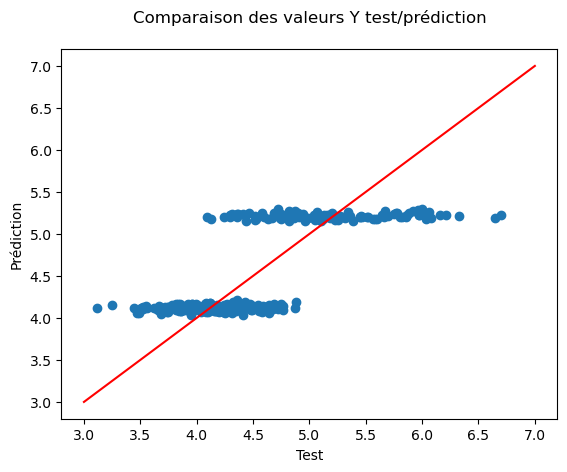

In [420]:
plt.figure()
plt.title('Comparaison des valeurs Y test/prédiction',y=1.05)

plt.scatter(Y_test,Y_pred)
plt.plot([3,7],[3,7],c='red')
plt.xlabel('Test')
plt.ylabel('Prédiction')

plt.show()

La courbe rouge représente tout simplement Y_test = Y_pred

Plus le résultat prédit est proche de la vraie valeur, plus le point est proche de cette courbe rouge

Idéalement, j'aurais aimé avoir des points formant un groupe proche de la courbe et suivant son allure

Ici, ce n'est clairement pas le cas, il y a même 2 groupes formant plutôt 2 lignes horizontales, en effet les valeurs prédites correspondantes à ces 2 groupes se situent dans un petit intervalle par rapport à l'intervalle des vraies valeurs

Pour le 1er groupe, on part sur des valeurs test comprises entre 3 et 4.9 pour des valeurs prédites comprises entre 4 et 4.3

Pour le 2nd groupe, on part sur des valeurs test comprises entre 4 et 6.8 pour des valeurs prédites comprises entre 5.1 et 5.4

Lors de l'analyse explorative, on a pu voir que la variables 'marge inf' faisait partie avec 'long' des variables présentant les différences les plus importantes entre vrais et faux billets. Forcément, il semble que ces 2 groupes de points bien distincts soient dûs à la variable 'Vrai' et que cette variable soit celle qui est la plus significativement explicative et de loin, ce qui peut également dire que certaines variables explicatives sont en fait non-significativemnt explicatives 

D'ailleurs, on avait regarder la matrice de corrélation avant de transformer la variable 'Vrai' en quantitative, maintenant que ceci est fait il peut-être intéressant de regarder la corrélation qu'à cette variables avec les autres

In [421]:
billets_nn_corr = billets_nn.corr(method='spearman')
def rg(val):
    
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

billets_nn_corr_rg = billets_nn_corr.style.applymap(rg).applymap(lambda v: 'opacity: 40%;' if (v < 0.4) and (v > -0.4) else None)
                                         
billets_nn_corr_rg

,diag,haut gauche,haut droite,marge inf,marge sup,long,Vrai
diag,1.000000,0.018803,-0.023928,-0.104360,-0.053500,0.099832,0.130537
haut gauche,0.018803,1.000000,0.247550,0.297401,0.259265,-0.303910,-0.389150
haut droite,-0.023928,0.247550,1.000000,0.396651,0.303102,-0.372777,-0.493245
marge inf,-0.104360,0.297401,0.396651,1.000000,0.421361,-0.587506,-0.752898
marge sup,-0.053500,0.259265,0.303102,0.421361,1.000000,-0.479455,-0.613290
long,0.099832,-0.303910,-0.372777,-0.587506,-0.479455,1.000000,0.791935
Vrai,0.130537,-0.389150,-0.493245,-0.752898,-0.613290,0.791935,1.000000


Sans suprise, la variable 'Vrai' présentent de fortes corrélations avec 'long' et 'marge inf' (on retrouve le même ordre d'importance que je vais pu observer via le pairplot)

De plus, si chacun des groupes de points correspond aux vrais ou faux billets, les intervalles de prédictions étant très fins, ils semblent aussi être proches de la moyenne ou de la médiane de 'marge_inf' des 2 types de billets 

In [422]:
print('Moyenne des faux : ',round(billets_nn['marge inf'].loc[billets_nn['Vrai']==0].mean(),2))
print('Médiane des faux : ',billets_nn['marge inf'].loc[billets_nn['Vrai']==0].median())
print('Moyenne des vrais : ',round(billets_nn['marge inf'].loc[billets_nn['Vrai']==1].mean(),2))
print('Moyenne des vrais : ',round(billets_nn['marge inf'].loc[billets_nn['Vrai']==1].median(),2))

Moyenne des faux :  5.22
Médiane des faux :  5.19
Moyenne des vrais :  4.12
Moyenne des vrais :  4.11


En effet, les intervalles de prédictions des 2 groupes observés graphiquement sont proches des moyennes et des médianes

Ici, on a un algorithme qui nous donnerait une prédiction proche d'une imputation par la moyenne ou la médiane à quelques variations près

Également, quand on utilise un algorithme de régression linéaire, il existe des indicateurs permettant de mesurer la performance de l'agorithme

Il y a le R² (coefficient de détermination), qui est l'indicateur principal que l'on regarde. Il indique le taux de la variance expliquée de Y par les variables explicatives et est utilisé comme juge de qualité de la régression linéaire, plus il est élevé, meilleure est la régression

Également il y a d'autres indicateurs "secondaires' mesurant la performance de la régression : 

- MAE (erreur absolue moyenne)
- MSE (erreur quadratique moyenne)
- RMSE (Racine carré de MSE)

Plus ils sont faibles, meilleure est la performance de la régression

In [423]:
sk_r2 = metrics.r2_score(Y_test,Y_pred)
sk_mae = metrics.mean_absolute_error(Y_test,Y_pred)
sk_mse = metrics.mean_squared_error(Y_test,Y_pred)
sk_rmse = np.sqrt(metrics.mean_squared_error(Y_test,Y_pred))
print('R²',sk_r2)
print('MAE',sk_mae)
print('MSE',sk_mse)
print('RMSE',sk_rmse)

R² 0.6067037012833867
MAE 0.3384759273179325
MSE 0.18677321042027484
RMSE 0.4321726627405704


Ici on a 61% de la variance de Y expliquée par les Xi

Toutes ces valeurs nous serviront à titre comparatif avec l'algorithme proposé par STATSMODELS que l'on va utliser maintenant

# <font color='green'> 2) STATSMODELS 
    
Contrairement à la libraire SKLEARN pour laquelle ceci est fait automatiquement, il faut ajouter la constante avant d'utiliser l'algorithme

Bien évidemment, on utilise les mêmes bases d'entrainement/test pour avoir une comparaison pertinente des 2 librairies

In [424]:
X_train = sm.add_constant(X_train)

In [425]:
linreg_sm = sm.OLS(Y_train,X_train).fit()
linreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              marge inf   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     314.0
Date:                Sun, 17 Sep 2023   Prob (F-statistic):          3.69e-239
Time:                        08:25:51   Log-Likelihood:                -604.92
No. Observations:                1170   AIC:                             1224.
Df Residuals:                    1163   BIC:                             1259.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.9022      9.199      0.750      0.453     -11.146      24.950
diag           -0.0480      0.040     -1.207      0.228      -0.126       0.030
haut gauche     0.0357      0.043      0.837      0.403      -0.048       0.119
haut droite     0.0176      0.042      0.415      0.678      -0.065       0.101
marge sup      -0.1341      0.065     -2.054      0.040      -0.262      -0.006
long            0.0131      0.026      0.500      0.617      -0.038       0.064
Vrai           -1.1387      0.055    -20.686      0.000      -1.247      -1.031
==============================================================================
Omnibus:                       21.217   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.525
Skew:                           0.041   Prob(JB):                     2.61e-09
Kurtosis:                       3.897   Cond. No.                     1.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Déjà, on peut voir que STATSMODELS nous offre une visualisation avec beaucoup d'indicateurs statistiques

On retrouve le R² (R-squared) égal à 0.618, donc légèrement supérieur à celui de SKLEARN

L'ensemble des variables explicatives est affiché, avec leur coefficient (égaux à ceux de SKLEARN)

On a vu lorsqu'on a utilisé SKLEARN, que les résultats obtenues semblaient être fortement expliquée par la variable 'Vrai' et qu'il était probable que certaines des variables Xi ne soient pas significativement explicatives

Avec STATSMODELS, on peut voir qu'il y a une p-valeur associée à chaque variable explicative (P>|t|) et lorsqu'au moins un des Xi affiche une p-valeur supérieure à 0.05, on peut enlever un des Xi et recommencer l'algotithme, celui avec la p-valeur la plus élevée, car cet Xi ne sera pas significativement explicatif

Ici 'haut droite' a une p-valeur = 0.612, qui est la plus élevée

In [426]:
X_train = X_train.drop(columns='haut droite')
linreg_sm = sm.OLS(Y_train,X_train).fit()
linreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              marge inf   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     377.1
Date:                Sun, 17 Sep 2023   Prob (F-statistic):          1.97e-240
Time:                        08:25:52   Log-Likelihood:                -605.00
No. Observations:                1170   AIC:                             1222.
Df Residuals:                    1164   BIC:                             1252.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.4126      8.447      0.996      0.319      -8.160      24.985
diag           -0.0470      0.040     -1.186      0.236      -0.125       0.031
haut gauche     0.0370      0.042      0.871      0.384      -0.046       0.120
marge sup      -0.1339      0.065     -2.053      0.040      -0.262      -0.006
long            0.0133      0.026      0.507      0.612      -0.038       0.065
Vrai           -1.1447      0.053    -21.545      0.000      -1.249      -1.040
==============================================================================
Omnibus:                       21.283   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.696
Skew:                           0.041   Prob(JB):                     2.40e-09
Kurtosis:                       3.899   Cond. No.                     1.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On peut voir que les p-valeurs ont changé, mais il reste encore des Xi dont la p-valeur est supérieure à 0.05

C'est le cas de 'long'  avec une p-valeur = 0.612

In [427]:
X_train = X_train.drop(columns='long')
linreg_sm = sm.OLS(Y_train,X_train).fit()
linreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              marge inf   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     471.6
Date:                Sun, 17 Sep 2023   Prob (F-statistic):          9.69e-242
Time:                        08:25:53   Log-Likelihood:                -605.13
No. Observations:                1170   AIC:                             1220.
Df Residuals:                    1165   BIC:                             1246.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.9229      7.902      1.256      0.209      -5.582      25.427
diag           -0.0473      0.040     -1.192      0.233      -0.125       0.031
haut gauche     0.0371      0.042      0.874      0.382      -0.046       0.120
marge sup      -0.1337      0.065     -2.050      0.041      -0.262      -0.006
Vrai           -1.1239      0.034    -33.154      0.000      -1.190      -1.057
==============================================================================
Omnibus:                       21.008   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.919
Skew:                           0.043   Prob(JB):                     3.54e-09
Kurtosis:                       3.889   Cond. No.                     1.34e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'haut gauche' a une p-valeur = 0.382

In [428]:
X_train = X_train.drop(columns='haut gauche')
linreg_sm = sm.OLS(Y_train,X_train).fit()
linreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              marge inf   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     628.6
Date:                Sun, 17 Sep 2023   Prob (F-statistic):          5.21e-243
Time:                        08:25:53   Log-Likelihood:                -605.52
No. Observations:                1170   AIC:                             1219.
Df Residuals:                    1166   BIC:                             1239.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.4375      6.801      1.976      0.048       0.093      26.782
diag          -0.0453      0.040     -1.144      0.253      -0.123       0.032
marge sup     -0.1320      0.065     -2.024      0.043      -0.260      -0.004
Vrai          -1.1325      0.032    -34.909      0.000      -1.196      -1.069
==============================================================================
Omnibus:                       20.887   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.680
Skew:                           0.040   Prob(JB):                     3.99e-09
Kurtosis:                       3.887   Cond. No.                     9.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'diag' a une p-valeur = 0.253

In [429]:
X_train = X_train.drop(columns='diag')
linreg_sm = sm.OLS(Y_train,X_train).fit()
linreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              marge inf   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     942.0
Date:                Sun, 17 Sep 2023   Prob (F-statistic):          2.89e-244
Time:                        08:25:54   Log-Likelihood:                -606.17
No. Observations:                1170   AIC:                             1218.
Df Residuals:                    1167   BIC:                             1234.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6622      0.220     25.769      0.000       5.231       6.093
marge sup     -0.1337      0.065     -2.051      0.040      -0.262      -0.006
Vrai          -1.1373      0.032    -35.354      0.000      -1.200      -1.074
==============================================================================
Omnibus:                       21.780   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.200
Skew:                           0.034   Prob(JB):                     1.13e-09
Kurtosis:                       3.917   Cond. No.                         65.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Enfin, il n'y a plus de p-valeur > 0.05 et il ne reste plus que 2 variables qui sont considérées comme significativement explicatives : 'marge sup' et 'Vrai'

Mainteant on va regarder graphiquement ce que nous donne les valeurs test par rapport aux valeurs prédites, puis comparer aussi les autres indicateurs de performances

In [430]:
Y_pred = linreg_sm.predict(sm.add_constant(X_test[['marge sup','Vrai']]))

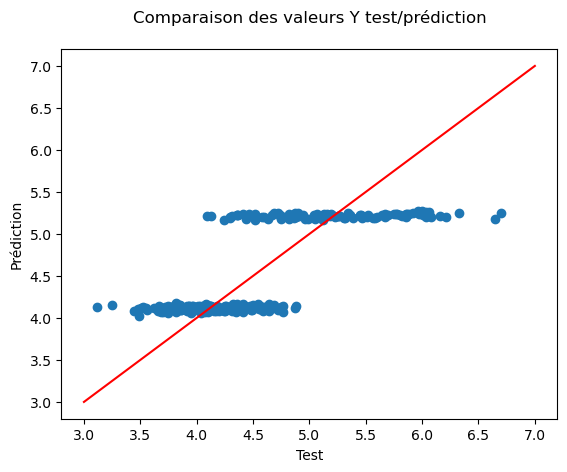

In [431]:
plt.figure()
plt.title('Comparaison des valeurs Y test/prédiction',y=1.05)

plt.scatter(Y_test,Y_pred)
plt.plot([3,7],[3,7],c='red')
plt.xlabel('Test')
plt.ylabel('Prédiction')

plt.show()

On retrouve des résultats très fortement similaires que ceux de SKLEARN

Au moins l'avantage avec STATSMODELS, c'est qu'on aurait déjà pu savoir les variables significativement explicatives

In [432]:
r2 = r2_score(Y_test,Y_pred)
mae = metrics.mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
df_metrics = pd.DataFrame({'Metrique':['R2','MSE','RMSE','MAE'],'Test':[r2,mse,rmse,mae]})
df_metrics

,Metrique,Test
0,R2,0.610136
1,MSE,0.185143
2,RMSE,0.430283
3,MAE,0.336213


In [433]:
print('R²',sk_r2)
print('MAE',sk_mae)
print('MSE',sk_mse)
print('RMSE',sk_rmse)

R² 0.6067037012833867
MAE 0.3384759273179325
MSE 0.18677321042027484
RMSE 0.4321726627405704


Pour STATSMODELS, R² est légèrement supérieur, et les MAE, MSE et RMSE sont aussi légèrement inférieure

Même si les différence ne sont pas énormes, pour ce cas-ci, l'algorithme de STATSMODELS est meilleur que celui de SKLEARN

Pour prédir les valeurs manquantes de marge_inf c'est donc le modèle de STATSMODELS que l'on gardera, mais encore faut-il que le modèle soit valide

Pour valider un modèle, il faut que celui-ci vérifie les 6 hypothèses suivantes :

- Linéarité
- Homoscédacité
- Absence de multicolinéarité
- Normalité des erreurs
- Autocorrélation (indépendance des erreurs)
- Nullité de l'espérance des erreurs (automatiquement validé par le modèle OLS de STATSMODELS)

## <font color='green'> 3) Hypothèses de validation !! REVOIR LES NOMS - NE PAS CONFONDRE ERREURS ET RESIDUS

### Linéarité

Cette hypothèse est tout simplement valide s'il existe une relation tel que :

Y = c0 + c1*X1 + c2*X2 + ... + cn*Xn + e

Pour vérifier la linéarité du modèle, il existe le test de Rainbow pour lequel l'hypothèse H0 est de rejeter la linéarité du modèle, avec H0 rejeté si la p-valeur > 0.05

Il est également possible lorsqu'il s'agit d'une régression linéaire simple (avec une seule variable explicative) de visualiser via un nuage de points si il y a un semblant de relation linéaire entre la variable à expliquer et la varibale explicative

In [434]:
sm.stats.diagnostic.linear_rainbow(linreg_sm)

(0.9446608141897896, 0.7540625617589709)

La p-valeur = 0.75, donc on rejette H0 et on ne rejette pas la linéarité du modèle

### Homoscédacité

La variance des résidus doit être constance

Pour vérifier l'homoscédacité du modèle, on peut utliser une identification graphique, si on observe une tendance particulière dans la variation des résidus par rapport aux valeurs prédites, alors l'homoscédacité n'est pas respectée

Également il y a le test de Breusch-Pagan qui soumet comme hypothèse H0 : Les termes d’erreurs du modèle ont une variance constante (donc vérife l'homoscédacité)

H0 est rejeté pour p_valeur > 0.05

In [435]:
Y_train_pred = linreg_sm.predict((X_train))
residus = Y_train - Y_train_pred

C:\Users\narab\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'rédisus')

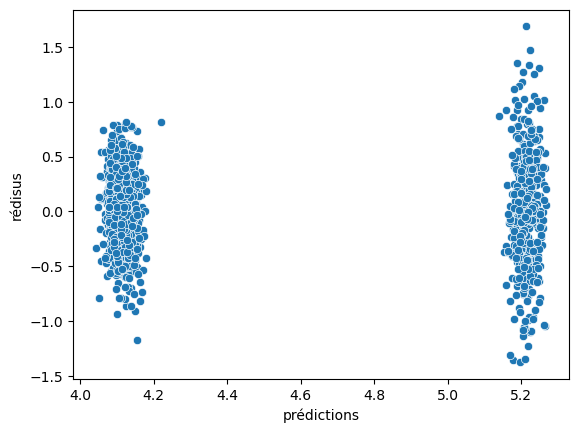

In [436]:
sns.scatterplot(Y_train_pred,residus)
plt.xlabel('prédictions')
plt.ylabel('rédisus')

Il ne semble pas y avoir de tendance particulière

In [437]:
bp_test = sm.stats.diagnostic.het_breuschpagan(linreg_sm.resid,linreg_sm.model.exog)
bp_test

(123.37183984792068,
 1.6223530361976033e-27,
 68.78036660202385,
 5.786608787489573e-29)

La 2ème valeur correspond à la p-valeur qui est est ici < 0.05, donc on ne rejette pas H0 et l'homoscédacité du modèle semble être valide

### Absence de multicolinéarité

Les variables ne doivent pas être fortement corrélées entre elle

Il existe un calcul permettant d'obetnir le VIF qui nous indique si les variables sont fortement corrélées entre elle

On considère que l'absence de multicolinéarité est validée si le VIF des variables explicatives ne dépassent pas un de 5, voire 10

In [438]:
vif=pd.DataFrame()
vif['VIF factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['features'] = X_train.columns
print(vif)

   VIF factor   features
0  341.438603      const
1    1.617936  marge sup
2    1.617936       Vrai


Les VIF de 'marge sup' et 'Vrai' sont inférieurs à 5, donc l'hypothèse est validée

### Normalité des termes d'erreurs

hypothèse : les résidus doivent suivre une loi Normale

In [439]:
resid_norm = linreg_sm.get_influence().resid_studentized_internal

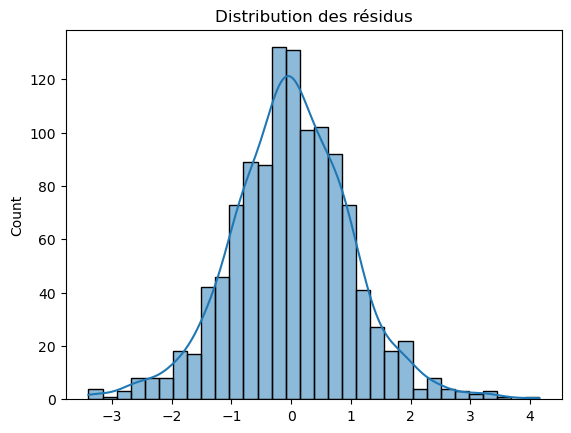

In [440]:
plt.figure()
plt.title('Distribution des résidus')
sns.histplot(resid_norm,kde=True)
plt.show()

A partir de ce graphique, il n'y a pas d'évidence pour dire que les résidus ne suivent pas une loi normale

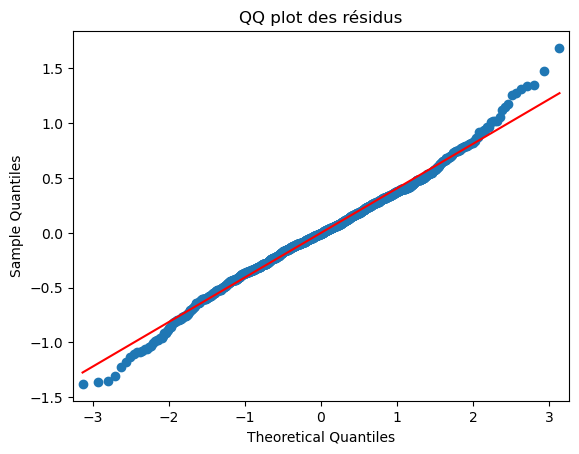

In [441]:
fig, ax = plt.subplots()
plt.title('QQ plot des résidus')
sm.qqplot(residus,line='s',ax=ax)
plt.show()

Sur ce graphique QQplot, on observe qu'au niveau des 2 extrémités les points s'éloignent de la courbe rouge, ce qui indiquerai que les résidus ne suivent une loi Normale 

In [442]:
shapiro_test = stats.shapiro(resid_norm)
shapiro_test

ShapiroResult(statistic=0.9921786785125732, pvalue=7.328602350753499e-06)

H0 = La distribution suit une loi normale

Si p-valeur < 0.05, alors H0 est rejetée

En effet le test de normalité des résidus est rejeté

### Autocorrélation

Les termes d'erreurs doivent être indépendants

Il existe le test de Durbin-Watson dont la valeur varie entre 0 et 4, plus la valeur du test est proche de 2, plus l'autocorrélation est nulle

Dans le sommaire de la régression linéaire de STATSMODELS, on peut directement observer la valeur de ce test. Pour ce modèle la valeur du test de Durbin-Watson est de 1.948, donc très proche de 2 et on peut considérer que l'autocorrélation comme nulle

### Espérance des erreurs

Cette hypothèse est déjà validé par le modèle OLS

### Récapituliatif

Pour ce modèle, 5 hypothèses sont vérifiées, mais celle de la normalité des termes d'erreurs ne l'est pas, ce qui signifie que la modèle n'est pas à 100% valide

Pour prédire, les valeurs d'une variable quantitative, il existe d'autres modèles qui auront sans doute valide et de meilleur qualité que celui-ci

Néanmoins je vais tout de même le garder et l'utiliser pour prédire les valeurs des lignes qui n'en avait pas

## <font color='green'> 4) Utilisation du modèle sur les valeurs nulles
    
J'avais séparer en 2 dataframes les billets avec une valeur non nulle pour 'marge inf' et ceux avec une valeur nulle, on a plus qu'à utiliser le modèle de STATSMODELS avec ce dernier dataframe

In [443]:
billets_vn.head()

,Vrai,diag,haut gauche,haut droite,marge inf,marge sup,long
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


Pour ce dataframe, il faut juste faire passer 'Vrai' en float prenant 1 pour True et 0 pour False, puis utliser le modèle de régression linéaire de STATSMODELS

In [444]:
col_vn = pd.get_dummies(billets_vn['Vrai'],drop_first=True,dtype=float)
billets_vn = pd.concat([billets_vn.drop(columns='Vrai'),col_vn],axis=1)
billets_vn.rename(columns={True:'Vrai'},inplace=True)
pred_vn = linreg_sm.predict(sm.add_constant(billets_vn[['marge sup','Vrai']]))
pred_vn

72      4.090322
99      4.105030
151     4.121075
197     4.040850
241     4.121075
251     4.130435
284     4.092996
334     4.123749
410     4.107704
413     4.102356
445     4.122412
481     4.162525
505     4.126424
611     4.083637
654     4.163862
675     4.182582
710     4.114390
739     4.111716
742     4.091659
780     4.106367
798     4.122412
844     4.125087
845     4.137120
871     4.114390
895     4.126424
919     4.179908
945     4.121075
946     4.087648
981     4.125087
1076    5.232994
1121    5.238343
1176    5.258399
1303    5.270433
1315    5.207590
1347    5.179511
1435    5.186196
1438    5.228983
dtype: float64

Ci-dessus, la liste des valeurs prédites pour 'marge inf' qu'on va ajouter au dataframe des valeurs nulles

In [445]:
billets_vn.drop(columns='marge inf',inplace=True)
billets_vn['marge inf'] = pred_vn
billets_vn.head()

,diag,haut gauche,haut droite,marge sup,long,Vrai,marge inf
72,171.94,103.89,103.45,3.25,112.79,1.0,4.090322
99,171.93,104.07,104.18,3.14,113.08,1.0,4.105030
151,172.07,103.80,104.38,3.02,112.93,1.0,4.121075
197,171.45,103.66,103.80,3.62,113.27,1.0,4.040850
241,171.83,104.14,104.06,3.02,112.36,1.0,4.121075


Il ne reste plus qu'à concaténer ce dataframe avec celui des valeurs non nulles, et on obtiendra le dataframe initial, mais sans aucune valeur nulle et prêt pour la détection des faux billets

In [446]:
billets = pd.concat([billets_nn,billets_vn])
billets.head()

,diag,haut gauche,haut droite,marge inf,marge sup,long,Vrai
0,171.81,104.86,104.95,4.52,2.89,112.83,1.0
1,171.46,103.36,103.66,3.77,2.99,113.09,1.0
2,172.69,104.48,103.50,4.40,2.94,113.16,1.0
3,171.36,103.91,103.94,3.62,3.01,113.51,1.0
4,171.73,104.28,103.46,4.04,3.48,112.54,1.0


In [447]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   diag         1500 non-null   float64
 1   haut gauche  1500 non-null   float64
 2   haut droite  1500 non-null   float64
 3   marge inf    1500 non-null   float64
 4   marge sup    1500 non-null   float64
 5   long         1500 non-null   float64
 6   Vrai         1500 non-null   float64
dtypes: float64(7)
memory usage: 93.8 KB


&nbsp;

# <font color='blue'> III - Détection des faux billets
    
&nbsp;
    
Pour détecter l'authenticité d'un billet, j'utiliserai 2 méthodes : la régression logistique (de STATSMODELS et de SKLEARN) et la méthode des K-means
    
Je ferai une comparaison des 3 résultats et garderai le meilleur
    
Cette fois-ci, la variable à prédire sera la variable 'Vrai' et les variables explicatives seront toutes les autres
    
Ces méthodes sont faites pour prédire des varibales qualitatives, donc je vais retransformer la variable 'Vrai' en qualitative (on peut garder les 1/0 à la place de True/False)    

In [448]:
billets['Vrai'] = billets['Vrai'].astype('category')

Je vais commencer par la régression logistique de STATSMODELS, comme pour la régression linéaire, on sépare la variable à expliquer et les variables explicatives, et on se garde 80% des données pour l'entrainement et 20% des données pour le test

In [449]:
X = billets.iloc[:,:-1]
Y = billets.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=3)

# <font color='green'> a) STATSMODELS

In [450]:
X_train = sm.add_constant(X_train)
logreg_sm = sm.Logit(Y_train,X_train).fit()

Optimization terminated successfully.
         Current function value: 0.025805
         Iterations 13


In [451]:
logreg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Vrai   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Sun, 17 Sep 2023   Pseudo R-squ.:                  0.9594
Time:                        08:26:08   Log-Likelihood:                -30.966
converged:                       True   LL-Null:                       -762.42
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -285.7096    292.800     -0.976      0.329    -859.587     288.168
diag            0.1779      1.326      0.134      0.893      -2.421       2.777
haut gauche    -1.7806      1.251     -1.423      0.155      -4.233       0.672
haut droite    -1.9829      1.234     -1.607      0.108      -4.401       0.435
marge inf      -6.4617      1.168     -5.532      0.000      -8.751      -4.172
marge sup     -11.7728      2.727     -4.318      0.000     -17.117      -6.429
long            6.3417      1.084      5.849      0.000       4.217       8.467
===============================================================================

Possibly complete quasi-separation: A fraction 0.56 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

De même que la régression linéaire, on a un résumé avec beaucoup d'informations dont une partie avec les variables explicatives, leur coefficient et leur p-valeur

Je vais réitérer le procédé vu précédèment avec la régression linéaire et retirer les variables non significativement explicatives

C'est la variable 'diag' avec une p-valeur de 0.56 qui sera retirer un première

In [452]:
X_train.drop(columns='diag',inplace=True)
logreg_sm = sm.Logit(Y_train,X_train).fit()
logreg_sm.summary()

Optimization terminated successfully.
         Current function value: 0.025813
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Vrai   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1194
Method:                           MLE   Df Model:                            5
Date:                Sun, 17 Sep 2023   Pseudo R-squ.:                  0.9594
Time:                        08:26:09   Log-Likelihood:                -30.975
converged:                       True   LL-Null:                       -762.42
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -254.1761    173.804     -1.462      0.144    -594.825      86.473
haut gauche    -1.7844      1.249     -1.429      0.153      -4.233       0.664
haut droite    -1.9979      1.227     -1.628      0.103      -4.403       0.407
marge inf      -6.5039      1.130     -5.755      0.000      -8.719      -4.289
marge sup     -11.7885      2.723     -4.330      0.000     -17.125      -6.452
long            6.3528      1.081      5.876      0.000       4.234       8.472
===============================================================================

Possibly complete quasi-separation: A fraction 0.57 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

C'est la variable 'haut gauche' avec une p-valeur de 0.226 qui sera ensuite retirer

In [453]:
X_train.drop(columns='haut gauche',inplace=True)
logreg_sm = sm.Logit(Y_train,X_train).fit()
logreg_sm.summary()

Optimization terminated successfully.
         Current function value: 0.026682
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Vrai   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Sun, 17 Sep 2023   Pseudo R-squ.:                  0.9580
Time:                        08:26:10   Log-Likelihood:                -32.018
converged:                       True   LL-Null:                       -762.42
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -380.7836    154.806     -2.460      0.014    -684.199     -77.369
haut droite    -2.6246      1.179     -2.227      0.026      -4.935      -0.314
marge inf      -6.7827      1.147     -5.914      0.000      -9.030      -4.535
marge sup     -11.8063      2.700     -4.373      0.000     -17.098      -6.515
long            6.4191      1.062      6.047      0.000       4.338       8.500
===============================================================================

Possibly complete quasi-separation: A fraction 0.58 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

A ce stade, toutes les variables restantes sont significativement explicatives

On va pouvoir maintenant utiliser ce modèle sur la base test, avec uniquement les 4 variables significativement explicatives et observer les résultats

In [454]:
pred_train = logreg_sm.predict(X_train)>0.5
pred_test = logreg_sm.predict(sm.add_constant(X_test.drop(columns={'diag','haut gauche'})))>0.5

In [455]:
print('TRAIN SET :\n\n',confusion_matrix(Y_train,pred_train))
tn, fp, fn, tp = confusion_matrix(Y_test,pred_test).ravel()
print(tn, fp, fn, tp)

TRAIN SET :

 [[392   6]
 [  2 800]]
101 1 1 197


La matrice ci-dessus montre les résultats du modèle sur la base d'entrainement

Sur 1200 billets, il y avait 398 faux billets et 802 vrais billets

Parmi les faux billets, 6 ont été considérés comme vrais

Parmi les vrais billets, 2 ont été considérés comme faux

Au total, il y a eut 8 mauvaises prédictions sur 1200, ce qui est assez peu (1/150)

Maintenant il faut surtout regarder ce que donne le modèle sur la base de test

In [456]:
print('TEST SET :\n\n',confusion_matrix(Y_test,pred_test))
tn, fp, fn, tp = confusion_matrix(Y_test,pred_test).ravel()
print(tn, fp, fn, tp)

TEST SET :

 [[101   1]
 [  1 197]]
101 1 1 197


Sur cette base, il y a 300 billets, soit 4 fois moins que la base d'entrainement

Sur 102 faux billets, 1 ont été considérés comme vrais

Sur 198 vrais billets, 1 a été considéré comme faux

Au total, il y a eut 2 mauvaises prédictions sur 300, ce qui est le même ratio que sur celui de la base d'entrainement (1/150)

In [457]:
print('TRAIN SET :\n\n',classification_report(Y_train,pred_train))

TRAIN SET :

               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       398
         1.0       0.99      1.00      1.00       802

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [458]:
print('TEST SET :\n\n',classification_report(Y_test,pred_test))

TEST SET :

               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       102
         1.0       0.99      0.99      0.99       198

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Ce qui m'intéresse surtout ici, c'est surtout l'accucary du modèle sur la base de test, ainsi que le recall des faux billets (c'est à dire le taux de faux billets ayant été correctement prédits)

Pour la base de test, on a accucary de 0.99 et un recall des faux billets de 0.99, ce sont ces données qu'on va comparer en priorité avec les autres méthodes

# <font color='green'> a) SKLEARN
    
Je vais reprendre les mêmes groupes que pour STATSMODELS pour avoir des résultats sur les mêmes bases d'entrainement et de test

In [459]:
X = billets.iloc[:,:-1]
Y = billets.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=3)

In [460]:
logreg_sk = LogisticRegression(solver='liblinear')
logreg_sk.fit(X_train,Y_train)

LogisticRegression(solver='liblinear')

In [461]:
print('intercept',logreg_sk.intercept_)
print('coeff',logreg_sk.coef_)
coeff = pd.DataFrame(logreg_sk.coef_.T,X.columns,columns=['Coefficients'])
coeff

intercept [-0.01179032]
coeff [[-0.27685429 -1.51982991 -1.78481508 -3.71735805 -3.21837897  3.72276765]]


,Coefficients
diag,-0.276854
haut gauche,-1.519830
haut droite,-1.784815
marge inf,-3.717358
marge sup,-3.218379
long,3.722768


On retrouve les coefficients associés à chaque variable, ainsi que la constante (intercept)

In [462]:
pred_train = logreg_sk.predict(X_train)
pred_test = logreg_sk.predict(X_test)

In [463]:
print('TRAIN SET :\n\n',confusion_matrix(Y_train,pred_train))
tn, fp, fn, tp = confusion_matrix(Y_train,pred_train).ravel()
print(tn, fp, fn, tp)

TRAIN SET :

 [[390   8]
 [  3 799]]
390 8 3 799


In [464]:
print('TEST SET :\n\n',confusion_matrix(Y_test,pred_test))
tn, fp, fn, tp = confusion_matrix(Y_test,pred_test).ravel()
print(tn, fp, fn, tp)

TEST SET :

 [[101   1]
 [  2 196]]
101 1 2 196


Pour la base d'entrainement on a 8 faux billets qui ont été prédits comme vrais et 3 vrais billets comme faux, soit 11 fausses prédictions sur 1200, ce qui en fait 3 de plus que pour le modèle de STATSMODELS

Il y a aussi 1 vrais billets de plus prédits comme un faux dans la base de test

In [465]:
print('TRAIN SET :\n\n',classification_report(Y_train,pred_train))

TRAIN SET :

               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       398
         1.0       0.99      1.00      0.99       802

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



In [466]:
print('TEST SET :\n\n',classification_report(Y_test,pred_test))

TEST SET :

               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       102
         1.0       0.99      0.99      0.99       198

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



Bon si on se fie au rapport de classification, avec 2 décimales, on a les mêmes chiffres en accuracy et en recall pour la base d'entrainement et la base test que ceux de STATSMODELS

La différence entre le modèle de SKLEARN et STATSMODELS n'est pas très marquée, néanmoins le modèle de STATSMODELS a mieux prédit que celui de SKLEARN

## <font color='green'> 3) K-means
    
Contrairement à la régression logistique qui est une méthode supervisée, on peut également utlisier des méthodes de classifications non supervisées à titre prédictif
    
Je vais utiliser la méthode des K-means qui va classer les données en 2 groupes en utilisant les variables de X, puis nous verrons si ces 2 groupes correspondent à un groupe de vrais billets et à un groupe de faux billets
    
Évidemment, on va reprendre la même base d'entrainement et de test que pour les régressions logistiques    

In [467]:
X = billets.iloc[:,:-1]
Y = billets.iloc[:,-1]
X_scal = pre.StandardScaler().fit_transform(X)
X_scal = pd.DataFrame(X_scal,index=X.index,columns=X.columns)
X_train, X_test, Y_train, Y_test = train_test_split(X_scal,Y,test_size=0.2,random_state=3)

In [468]:
km = cls.KMeans(n_clusters=2,init='k-means++',random_state=0)
km.fit(X_train)
pred_train = km.predict(X_train)
pred_test = km.predict(X_test)

In [469]:
print('TRAIN SET :\n\n',confusion_matrix(Y_train,pred_train))
tn, fp, fn, tp = confusion_matrix(Y_train,pred_train).ravel()
print(tn, fp, fn, tp)

TRAIN SET :

 [[ 10 388]
 [795   7]]
10 388 795 7


In [470]:
print('TEST SET :\n\n',confusion_matrix(Y_test,pred_test))
tn, fp, fn, tp = confusion_matrix(Y_test,pred_test).ravel()

TEST SET :

 [[  2 100]
 [195   3]]


Bon ici, les matrices de confusions sont légèrement différentes puisque les valeurs ne sont pas au même place car la méthode des K-means à inverser les valeurs 0 et 1 par rapport aux valeurs qu'on avait jusqu'à présent

Pour ce coup-ci, ce n'est pas très embêtant et on peut toujours comparer les résultats avec ceux de la régression logistique

Pour la base d'entrainement, il y 17 mauvaises prédictions dont 10 faux billets passés comme vrais

Pour la base de test, il y a 5 mauvaises prédictions dont 2 faux billets passés comme vrais

En comparaison avec la régression logistique de STATSMODELS, on est passé de 8 à 17 mauvaises prédictions pour la base d'entrainement et 2 à 5 mauvaises prédictions pour la base de test. L'accuracy et le recall des faux billets de la méthode des kmeans sont donc moins bons que ceux de STATSMODELS et la méthode des K-means ne sera pas retenu

## Récapitulatif

Après avoir utilisé 2 méthode de régressions linéaires issus de différentes libraires, ainsi qu'une méthode des K-means, on a pu constaster quelques différences dans les résultats

In [471]:
resultats = pd.DataFrame(([17,10,5,2],[11,8,3,1],[8,6,2,1]),['KMEANS','SKLEARN','STATSMODELS'],
                         columns=[['Train - Mauvaises predictions','Train - faux billets passés vrais',
                                   'Test - Mauvaises prédictions','Test - faux billets passés vrais']])
resultats

,Train - Mauvaises predictions,Train - faux billets passés vrais,Test - Mauvaises prédictions,Test - faux billets passés vrais
KMEANS,17,10,5,2
SKLEARN,11,8,3,1
STATSMODELS,8,6,2,1


Normalement on préfère regarder directement l'accuracy et le recall, mais pour ne pas avoir des valeurs identiques, notamment pour SKLEARN et STATSMODELS, cela me semble pertinent de comparer directement les mauvaises prédictions des 3 méthodes

Ici, le modèle de STATSMODELS est celui qui le plus petit nombre dans chacune des colonnes, c'est donc celui-ci que je vais garder pour détecter au mieux des faux billets sur d'autres bases de données

### Remarque :

Si pour ce cas, STATSMODELS a donné les meilleurs résultats, il se peut que ce ne soit pas toujours le cas, notamment à cause de la base d'entrainement de départ

En effet en changeant la base d'entrainement (sur python le random_state de la méthode train_test_split), les résultats seraient différents, et peut-être SKLEARN ou KMeans aurait eut de meilleurs résultats

Ceci étant dit, le modèle retenu a fourni des résultats très satisfaisants avec une accucary et un recall de 0.99, ce qui est amplement suffisant

&nbsp;

# <font color='blue'> IV) Automatisation du modèle

&nbsp;
    
Maintenant qu'un modèle a été choisi pour détecter les faux billets, il ne reste plus qu'à automatiser le processus avec une fonction pour obtenir directement le résultat de la prédiction (et accessoirement la probabilité pour que le billet soit prédit comme vrai)

In [472]:
billets_prod = pd.read_csv("C:\\Users\\narab\\Downloads\\billets_production.csv",sep=',')
billets_prod.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [473]:
def billets_predict(df):
    df1 = df.copy()
    df1.rename(columns={'diagonal':'diag','height_left':'haut gauche','height_right':'haut droite',
                        'margin_low':'marge inf','margin_up':'marge sup','length':'long'},inplace=True)
    df1.drop(columns={'diag','haut gauche','id'},inplace=True)
    df1 = sm.add_constant(df1)
    df_prob = logreg_sm.predict(df1) # Probabilité d'être détecter comme vrai billet
    df['Prob (True)'] = round(df_prob,4) 
    df_pred = logreg_sm.predict(df1)>0.5 # Renvoi False pour les faux billets et True pour les vrais billets
    df['Predict'] = df_pred 
    return df    

In [474]:
billets_predict(billets_prod)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prob (True),Predict
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.0000,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.0000,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.0000,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.9978,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.0000,True


En n'oublians pas de renommer les variables en ma version francisée et en supprimant les inutiles pour le modèle, j'obtient en retour de la fonction, le même dataframe avec la colonne 'Prediction' en plus qui m'affiche comme pour la colonne 'Vrai' : False pour les faux billets et True pour les vrais

### Test avec un nouveau fichier

In [ ]:
billets_test = pd.read_csv("C:\\Users\\narab\\Downloads\\.csv",sep=',')
billets_predict(billets_test)

In [ ]:
*.to_csv("C:\\Users\\narab\\OneDrive\\Documents\\OpenClassRooms\\.csv",index=False)